In [1]:
''' 1. module import'''
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
''' 2. 딥러닝 모델을설계할 때 활용하는 장비 확인'''
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, 'Device:', DEVICE)
# Using PyTorch version: 1.4.0 Device: cuda => GPU 이용

Using PyTorch version: 1.5.0+cu92 Device: cuda


In [3]:
BATCH_SIZE = 32 #미니배치 1개당 32개의 데이터로 구성
#미니배치를 통해 학습하는 횟수 : 'Iteration'
#전체 데이터를 이용해 학습을 진행한 횟수 :'Epoch'
EPOCHS = 10

In [4]:
''' 3. FashionMNIST 데이터 다운로드(train, test set 분리)'''
train_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                              train=True,
                              download=True,
                              transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = '../data/FashionMNIST',
                              train=False,
                              transform = transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle=False)

In [5]:
len(train_loader.dataset)

60000

In [6]:
''' 4. 데이터 확인(1)'''
for (x_train, y_train) in train_loader:
    print('x_train:', x_train.size(), 'type:', x_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    print(x_train, y_train)
    break
    
# x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
# [mini-batch, channel, height, width]

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor
tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0

In [ ]:
''' 5. 데이터 확인(2)'''
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1) #(nrows,ncols,index)
    plt.axis('off')
    plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28), cmap='gray_r')
    plt.title('Class: ' + str(y_train[i].item()))
    

In [8]:
''' 6. Auto Encoder(AE)모델 설계-drop out 설정(인코더와 디코더로 이루어져있음)'''
class AE(nn.Module): #nn.Module클래스를 상속받는 AE클래스 정의
    def __init__(self): #AE클래스의 인스턴스 생성했을 때 지니게 되는 성질 정의
        super(AE, self).__init__() #nn.Module내에 있는 메스드 상속받아 이용
        
        self.encoder = nn.Sequential( #인코더 단위를 한번에 정의
            nn.Linear(28 * 28, 512), #FashionMNIST데이터는 28*28크기의 이미지데이터. 첫번째 레이어의 output을 512크기로 설정
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),) #Latent Variable Vector의 크기를 32로 설정하기 위해 output의 노드수를 32로 설정
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 256), #Latent Variable Vector을 input으로 이용하기 위해 디코더의 첫번째 레이어의 노드수를 32로 설정
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),) #output의 노드수는 원래 이미지 데이터와 loss를 계산하기 때문에 기존 이미지 데이터의 크기인 28*28크기로 노드 수 설정
        
    def forward(self, x): #AutoEncoder의 인코더와 디코더에 대해 Forward Propagation
        encoded = self.encoder(x) #이미지 데이터를 사전에 정의한 인코더의 input으로 이용해 Latent variable vector를 생성. 생성된 Latent variable vector을 encoded로 저장
        decoded = self.decoder(encoded)
        return encoded, decoded

In [9]:
''' 7. Optimizer, Object Function 설정'''
model = AE().to(DEVICE)
# 역전파를 이용해 파라미터를 업데이트 할 때 이용하는 optimizer를 정의
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#AE모델의 output값과 계산될 label값은 이미지 데이터 그 자체. 
#AE모델의 output값은 input으로 이용된 이미지 데이터와 복원된 이미지 데이터 값 간의 MSE계산
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [10]:
''' 8. MLP모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def train(model, train_loader, optimizer, log_interval):
    #AE모델을 학습상태로 지정
    model.train()
    #레이블 데이터를 활용해 학습하는 것이 아니라 입력데이터를 타깃으로 학습하기 때문에 레이블 데이터 이용할 필요 없음.
    for batch_idx,(image, _) in enumerate(train_loader):
        #AutoEncoder의 input은 28*28크기의 1차원 레이어이므로 2차원이미지 데이터를 1차원 데이터로 재구성해 할당.
        image = image.view(-1, 28*28).to(DEVICE)
        target = image.view(-1, 28*28).to(DEVICE)
        
        # 과거에 이용한 미니배치 내에 있는 이미지데이터와 레이블데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당돼 있으므로 
        # optimizer의 gradient를 초기화
        optimizer.zero_grad()
        #장비에 할당한 이미지 데이터를 AE모델의 input으로 이용해 output계산
        encoded, decoded = model(image)
        
        #계산된 output과 장비에 할당된 레이블 데이터를 기존에 정의한 MSE를 이용해 loss값 계산
        loss = criterion(decoded,target)
        
        #loss값을 계산한 결과를 바탕으로 역전파를 이용해 계산된 gradient값을 각 파라미터에 할당
        loss.backward()
        
        #각 파라미터에 할당된 gradient값을 이용해 파라미터값 업데이트
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(
            Epoch, batch_idx*len(image),
            len(train_loader.dataset), 100.*batch_idx/len(train_loader), loss.item()))

In [11]:
''' 9. 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의'''
def evaluate(model, test_loder): #모델 성능 평가
    #학습 과정 또는 학습이 완료된 AE모델을 학습 상태가 아닌, 평가 상태로 지정
    model.eval()
    #test_loader내의 데이터를 이용해 loss값을 계산하기 위해 test_loss를 0으로 임시설정
    test_loss=0
    
    #학습 과정 속에서 AutoEncoder에 이용되는 실제 이미지 데이터를 리스트에 저장하기위해 빈 리스트 할당
    real_image=[]
    
    #학습 과정 속에서 AutoEncoder을 통해 생성되는 이미지 데이터를 리스트에 저장하기위해 빈 리스트 할당
    gen_image=[]
    
    #모델 평가단계에서 gradient를 통해 파라미터 값이 업데이트 되는 현상을 방지하기 위해 torch.no_grad()메서드 이용해 gradient흐름 억제
    with torch.no_grad():
        for image, _ in test_loader:
            #미니배치 내에 있는 이미지 데이터를 이용해 AE모델을 검증
            #Auto Encoder의 input으로 이용하기 위해 trian함수에서와 같이 이미지를 28*28크기의 1차원 데이터로 재구성해 할당
            image = image.view(-1,28*28).to(DEVICE)
            #미니배치 내에 있는 이미지 데이터를 이용해 AE모델의 output과 비교
            target = image.view(-1,28*28).to(DEVICE)
            #장비에 할당한 이미지 데이터를 AE모델의 input으로 이용해 output계산
            encoded, decoded = model(image)
            
            #모델을 통해 생성된 이미지와 실제 이미지 간 MSE값 계산해서 test_loss업데이트
            test_loss += criterion(decoded, image).item()
            real_image.append(image.to('cpu')) #실제 이미지로 할당된 이미지를 리스트에 추가
            gen_image.append(decoded.to('cpu')) #모델을 통해 생성된 이미지를 리스트에 추가
            
    #현재까지 계산된 test_loss값을 test_loader내에 있는 데이터 개수만큼 나눠 평균 loss값으로 계산
    test_loss /= len(test_loader.dataset)
    return test_loss, real_image, gen_image

Train Epoch: 1 [0/60000(0%)]	Train Loss: 0.015329
Train Epoch: 1 [6400/60000(11%)]	Train Loss: 0.014868
Train Epoch: 1 [12800/60000(21%)]	Train Loss: 0.013213
Train Epoch: 1 [19200/60000(32%)]	Train Loss: 0.012890
Train Epoch: 1 [25600/60000(43%)]	Train Loss: 0.014559
Train Epoch: 1 [32000/60000(53%)]	Train Loss: 0.012491
Train Epoch: 1 [38400/60000(64%)]	Train Loss: 0.014889
Train Epoch: 1 [44800/60000(75%)]	Train Loss: 0.012099
Train Epoch: 1 [51200/60000(85%)]	Train Loss: 0.013508
Train Epoch: 1 [57600/60000(96%)]	Train Loss: 0.012098

[EPOCH:1], 	Test Loss: 0.0004


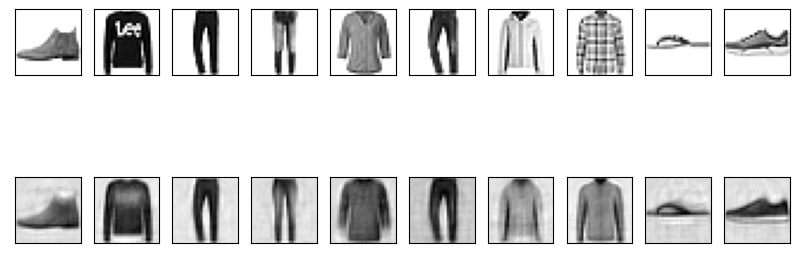

Train Epoch: 2 [0/60000(0%)]	Train Loss: 0.011679
Train Epoch: 2 [6400/60000(11%)]	Train Loss: 0.014218
Train Epoch: 2 [12800/60000(21%)]	Train Loss: 0.010981
Train Epoch: 2 [19200/60000(32%)]	Train Loss: 0.012358
Train Epoch: 2 [25600/60000(43%)]	Train Loss: 0.013113
Train Epoch: 2 [32000/60000(53%)]	Train Loss: 0.011875
Train Epoch: 2 [38400/60000(64%)]	Train Loss: 0.013660
Train Epoch: 2 [44800/60000(75%)]	Train Loss: 0.011603
Train Epoch: 2 [51200/60000(85%)]	Train Loss: 0.011566
Train Epoch: 2 [57600/60000(96%)]	Train Loss: 0.011336

[EPOCH:2], 	Test Loss: 0.0004


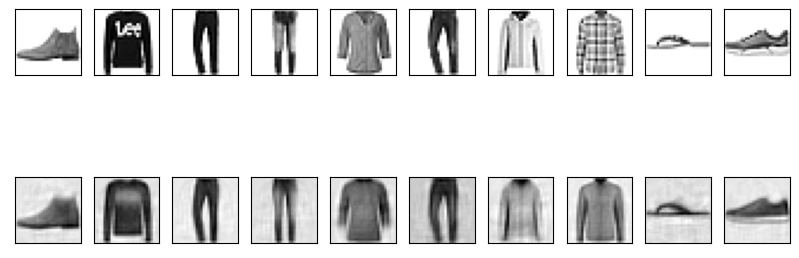

Train Epoch: 3 [0/60000(0%)]	Train Loss: 0.013012
Train Epoch: 3 [6400/60000(11%)]	Train Loss: 0.015307
Train Epoch: 3 [12800/60000(21%)]	Train Loss: 0.012193
Train Epoch: 3 [19200/60000(32%)]	Train Loss: 0.009398
Train Epoch: 3 [25600/60000(43%)]	Train Loss: 0.015484
Train Epoch: 3 [32000/60000(53%)]	Train Loss: 0.010100
Train Epoch: 3 [38400/60000(64%)]	Train Loss: 0.013757
Train Epoch: 3 [44800/60000(75%)]	Train Loss: 0.010045
Train Epoch: 3 [51200/60000(85%)]	Train Loss: 0.011616
Train Epoch: 3 [57600/60000(96%)]	Train Loss: 0.011051

[EPOCH:3], 	Test Loss: 0.0004


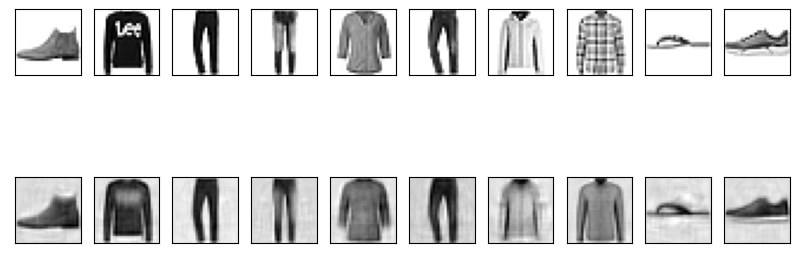

Train Epoch: 4 [0/60000(0%)]	Train Loss: 0.009530
Train Epoch: 4 [6400/60000(11%)]	Train Loss: 0.011986
Train Epoch: 4 [12800/60000(21%)]	Train Loss: 0.009187
Train Epoch: 4 [19200/60000(32%)]	Train Loss: 0.010210
Train Epoch: 4 [25600/60000(43%)]	Train Loss: 0.010072
Train Epoch: 4 [32000/60000(53%)]	Train Loss: 0.011513
Train Epoch: 4 [38400/60000(64%)]	Train Loss: 0.009663
Train Epoch: 4 [44800/60000(75%)]	Train Loss: 0.010423
Train Epoch: 4 [51200/60000(85%)]	Train Loss: 0.011438
Train Epoch: 4 [57600/60000(96%)]	Train Loss: 0.009422

[EPOCH:4], 	Test Loss: 0.0003


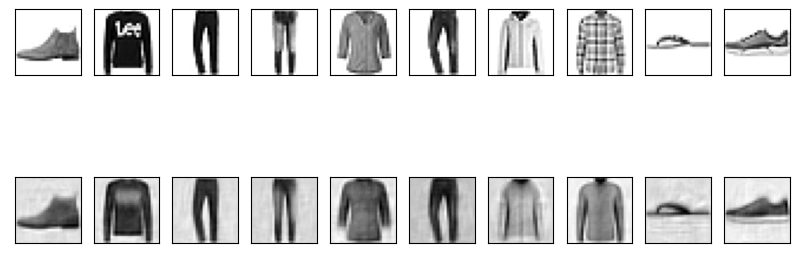

Train Epoch: 5 [0/60000(0%)]	Train Loss: 0.011363
Train Epoch: 5 [6400/60000(11%)]	Train Loss: 0.012815
Train Epoch: 5 [12800/60000(21%)]	Train Loss: 0.010558
Train Epoch: 5 [19200/60000(32%)]	Train Loss: 0.008989
Train Epoch: 5 [25600/60000(43%)]	Train Loss: 0.010457
Train Epoch: 5 [32000/60000(53%)]	Train Loss: 0.010018
Train Epoch: 5 [38400/60000(64%)]	Train Loss: 0.010217
Train Epoch: 5 [44800/60000(75%)]	Train Loss: 0.007697
Train Epoch: 5 [51200/60000(85%)]	Train Loss: 0.011365
Train Epoch: 5 [57600/60000(96%)]	Train Loss: 0.008813

[EPOCH:5], 	Test Loss: 0.0003


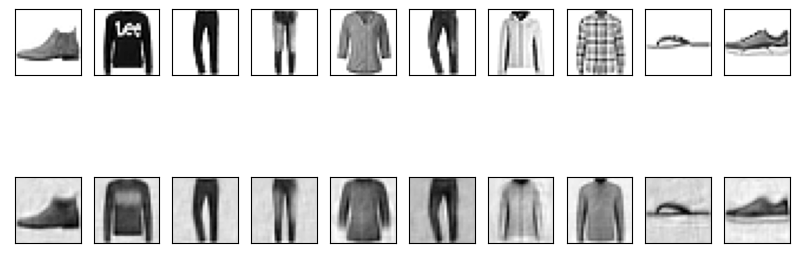

Train Epoch: 6 [0/60000(0%)]	Train Loss: 0.011192
Train Epoch: 6 [6400/60000(11%)]	Train Loss: 0.009826
Train Epoch: 6 [12800/60000(21%)]	Train Loss: 0.008556
Train Epoch: 6 [19200/60000(32%)]	Train Loss: 0.008358
Train Epoch: 6 [25600/60000(43%)]	Train Loss: 0.011218
Train Epoch: 6 [32000/60000(53%)]	Train Loss: 0.011006
Train Epoch: 6 [38400/60000(64%)]	Train Loss: 0.009528
Train Epoch: 6 [44800/60000(75%)]	Train Loss: 0.011168
Train Epoch: 6 [51200/60000(85%)]	Train Loss: 0.008534
Train Epoch: 6 [57600/60000(96%)]	Train Loss: 0.008048

[EPOCH:6], 	Test Loss: 0.0003


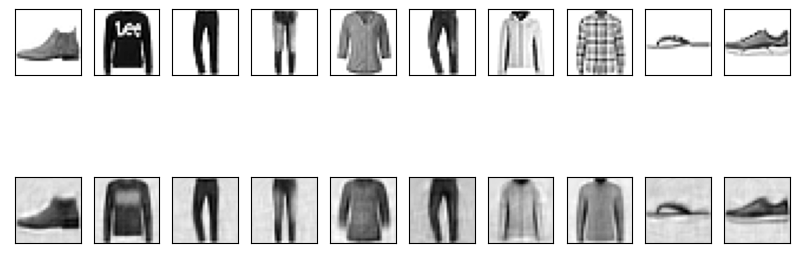

Train Epoch: 7 [0/60000(0%)]	Train Loss: 0.009809
Train Epoch: 7 [6400/60000(11%)]	Train Loss: 0.010976
Train Epoch: 7 [12800/60000(21%)]	Train Loss: 0.009225
Train Epoch: 7 [19200/60000(32%)]	Train Loss: 0.010384
Train Epoch: 7 [25600/60000(43%)]	Train Loss: 0.010098
Train Epoch: 7 [32000/60000(53%)]	Train Loss: 0.012572
Train Epoch: 7 [38400/60000(64%)]	Train Loss: 0.012067
Train Epoch: 7 [44800/60000(75%)]	Train Loss: 0.010030
Train Epoch: 7 [51200/60000(85%)]	Train Loss: 0.008262
Train Epoch: 7 [57600/60000(96%)]	Train Loss: 0.009638

[EPOCH:7], 	Test Loss: 0.0003


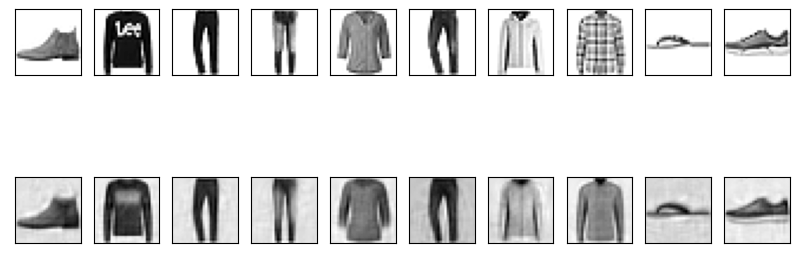

Train Epoch: 8 [0/60000(0%)]	Train Loss: 0.010691
Train Epoch: 8 [6400/60000(11%)]	Train Loss: 0.010930
Train Epoch: 8 [12800/60000(21%)]	Train Loss: 0.008527
Train Epoch: 8 [19200/60000(32%)]	Train Loss: 0.009783
Train Epoch: 8 [25600/60000(43%)]	Train Loss: 0.011397
Train Epoch: 8 [32000/60000(53%)]	Train Loss: 0.009837
Train Epoch: 8 [38400/60000(64%)]	Train Loss: 0.009814
Train Epoch: 8 [44800/60000(75%)]	Train Loss: 0.011077
Train Epoch: 8 [51200/60000(85%)]	Train Loss: 0.008747
Train Epoch: 8 [57600/60000(96%)]	Train Loss: 0.010964

[EPOCH:8], 	Test Loss: 0.0003


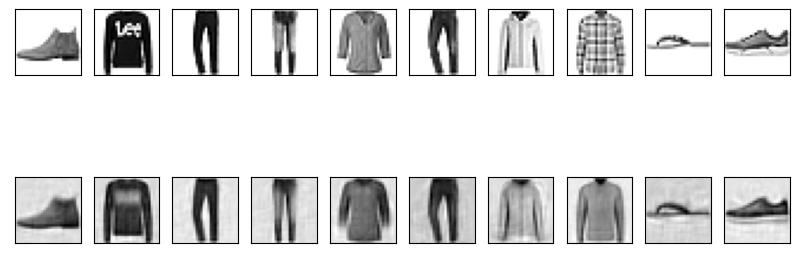

Train Epoch: 9 [0/60000(0%)]	Train Loss: 0.007520
Train Epoch: 9 [6400/60000(11%)]	Train Loss: 0.008494
Train Epoch: 9 [12800/60000(21%)]	Train Loss: 0.009753
Train Epoch: 9 [19200/60000(32%)]	Train Loss: 0.009261
Train Epoch: 9 [25600/60000(43%)]	Train Loss: 0.010781
Train Epoch: 9 [32000/60000(53%)]	Train Loss: 0.010271
Train Epoch: 9 [38400/60000(64%)]	Train Loss: 0.008777
Train Epoch: 9 [44800/60000(75%)]	Train Loss: 0.010748
Train Epoch: 9 [51200/60000(85%)]	Train Loss: 0.011232
Train Epoch: 9 [57600/60000(96%)]	Train Loss: 0.010941

[EPOCH:9], 	Test Loss: 0.0003


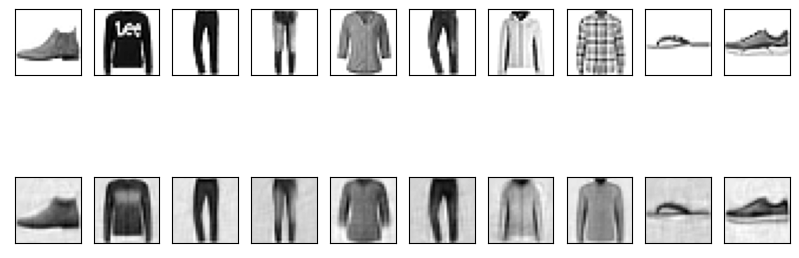

Train Epoch: 10 [0/60000(0%)]	Train Loss: 0.008159
Train Epoch: 10 [6400/60000(11%)]	Train Loss: 0.009799
Train Epoch: 10 [12800/60000(21%)]	Train Loss: 0.009378
Train Epoch: 10 [19200/60000(32%)]	Train Loss: 0.011039
Train Epoch: 10 [25600/60000(43%)]	Train Loss: 0.008996
Train Epoch: 10 [32000/60000(53%)]	Train Loss: 0.009438
Train Epoch: 10 [38400/60000(64%)]	Train Loss: 0.010130
Train Epoch: 10 [44800/60000(75%)]	Train Loss: 0.008421
Train Epoch: 10 [51200/60000(85%)]	Train Loss: 0.008442
Train Epoch: 10 [57600/60000(96%)]	Train Loss: 0.012394

[EPOCH:10], 	Test Loss: 0.0003


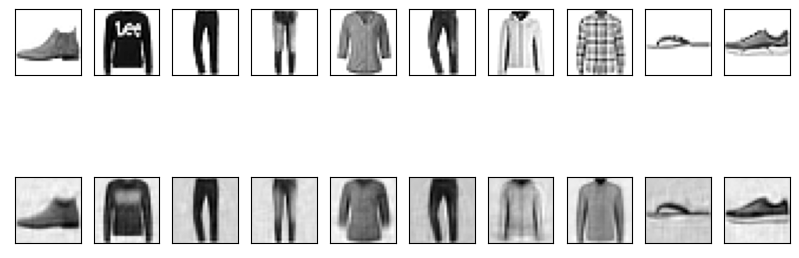

In [15]:
''' 10. AutoEncoder 학습을 실행하며 test set의 Reconstruction error 확인'''
for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval=200)
    test_loss, real_image, gen_image = evaluate(model, test_loader)
    print("\n[EPOCH:{}], \tTest Loss: {:.4f}".format(
    Epoch, test_loss))
    f, a = plt.subplots(2, 10, figsize=(10,4))
    for i in range(10): #실제 이미지 출력
        img = np.reshape(real_image[0][i], (28, 28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
        
    for i in range(10): #생성된 이미지 출력
        img = np.reshape(gen_image[0][i], (28, 28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()